In [38]:
import os

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
from datetime import timedelta
from datetime import datetime

import sklearn
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

import yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer



#always remember your magic function if using Jupyter
%matplotlib inline

%pylab inline

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
os.chdir('/Users/alexandrejacqueline/Data_Science/P5_DATA')

data  = pd.read_csv('data.csv', sep=',')


data["order_total_cost"] = data["price"]+data["freight_value"]

Populating the interactive namespace from numpy and matplotlib


In [39]:
data = data[(data['order_purchase_timestamp'] > "2017-01-01")]

In [40]:
# Par défaut, on va se placer 6 mois avant la dernière commande
def choix_df(data, date_debut=date(2017, 1, 1),
             date_fin=date(2017, 6, 29)):
    """
    Prend un Dataframe qui va être filtrer selon la date de début
    et la date de fin indiquées en paramètres. Les colonnes du
    dataframe seront groupées selon certaines fonctions (moyenne,
    somme, compter et minimum). Enfin, ajoute une colonne
    correspondant à la fréquence d'achat d'un client sur la
    période étudiée.

            Parameters:
                data : dataframe à utiliser
                date_debut (date object) : date de début du filtrage
                date_fin (date object) : date de fin du filtrage
    """
    data = df0.copy()

    # On commence par ne garder que la période qui nous intéresse
    data = data[(data['order_purchase_timestamp'] >= date_debut)
                & (data['order_purchase_timestamp'] <= date_fin)]

    # Date de la dernière commande du jeu de données
    jour_max = data['order_purchase_timestamp'].max()

    # Date de la première commande du jeu de données
    jour_min = data['order_purchase_timestamp'].min()

    # Nombre de jour au total
    nb_jours = (jour_max - jour_min).days

    # Temps entre la commande du client et la dernière date du jeu de données
    data['time_delta'] = (data['order_purchase_timestamp'].max()
                          - data['order_purchase_timestamp'])

    # On transforme "time_delta" pour n'avoir que les jours en nombres entiers
    data['time_delta'] = data['time_delta'].dt.days

    # On crée les colonnes que l'on veut
    data = (data.groupby('customer_unique_id').agg(
        nb_commandes=('order_id', 'count'), score_moy=('review_score',
                                                       'mean'),
        nb_paiements=('payment_installments', 'mean'),
        nb_produits=('order_item_id', 'mean'),
        recence=('time_delta', 'min'),
        montant_total=('order_total_cost', 'sum')))

    # On veut des nombres entiers pour certaines colonnes
    for col in ['score_moy', 'nb_paiements', 'nb_produits']:
        data[col] = data[col].astype(int)

    # On crée une colonne de fréquence d'achat
    data['frequence_achat'] = round(data['nb_commandes'] / nb_jours, 4)

    return(data)


In [41]:
# Preprocessing
def preprocessing(data):
    """
    Prend un DataFrame et passe les colonnes les plus concentrées sur des
    faibles valeurs au logarithme. Prend ensuite toutes les features numériques
    pour les centrer (on soustrait la moyenne de la feature) et les réduire
    (diviser par l'écart-type de la feature) à l'aide d'un StandardScaler.

            Parameters:
                data : DataFrame à utiliser
    """
    # On passe quelques colonnes au log
    transformer = FunctionTransformer(func=np.log, inverse_func=np.exp)

    cols_to_log = ['nb_commandes', 'nb_paiements', 'nb_produits',
                   'montant_total', 'frequence_achat']

    for col in cols_to_log:
        data[col] = transformer.fit_transform(data[col])

    # On standardise nos colonnes
    cols_to_scale = ['nb_commandes', 'score_moy', 'nb_paiements',
                     'nb_produits', 'recence', 'montant_total',
                     'frequence_achat']

    scaler = StandardScaler()

    data[cols_to_scale] = scaler.fit_transform(data[cols_to_scale])

In [42]:


# Elbow plot
def elbow_k_means(data):
    """
    Prend un Dataframe et lui applique un algorithme de clustering
    (k means) pour différents nombres de cluster (entre 2 et 9) et
    retourne le temps mis pour appliquer chacun des modèles à nos
    données ainsi que la valeur de distortion de chaque clustering sous
    la forme de graphique.
    La valeur de distortion correspond à la somme des distances au carré
    entre un point et le centre de son cluster. Le point d'inflexion
    de la courbe sera indiqué (si existant).

            Parameters:
                data : DataFrame à utiliser
    """
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(2, 10))

    visualizer.fit(data)
    visualizer.show()



In [43]:
# Silhouette plot
def silhouette_k_means(data, model):
    """
    Prend un Dataframe et lui applique l'algorithme de clustering
    souhaité. Calcule la densité de chaque cluster (comprise entre
    -1 et 1) en utilisant la coefficient de silhouette de chaque
    échantillon. Ce coefficient est la différence entre la distance
    moyenne intra-cluster et la distance moyenne avec le cluster
    le plus proche pour chaque échantillon, le tout normalisé par la
    valeur maximale.

            Parameters:
                data : DataFrame à utiliser
                model : modèle de clustering à appliquer
    """
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

    visualizer.fit(data)
    visualizer.show()

In [44]:
df0 = data.drop(columns=['Unnamed: 0'])

In [77]:
# On transforme notre colonne de date en datetime
df0['order_purchase_timestamp'] = pd.to_datetime(
    df0['order_purchase_timestamp'], format='%Y-%m-%d')

# On enlève les heures - minutes - secondes, on ne garde que la date
df0['order_purchase_timestamp'] = df0['order_purchase_timestamp'].dt.date


In [46]:
df0['order_purchase_timestamp'].min()

datetime.date(2017, 1, 5)

In [36]:
#df0 = df0.dropna()

In [47]:
# Toutes les données sauf les 6 derniers mois
df_ini = choix_df(df0)

In [48]:
# On passe quelques colonnes au log
transformer_ini = FunctionTransformer(func=np.log, inverse_func=np.exp)

cols_to_log = ['nb_commandes', 'nb_paiements', 'nb_produits',
               'montant_total', 'frequence_achat']

for col in cols_to_log:
    df_ini[col] = transformer_ini.fit_transform(df_ini[col])

df_ini.head(3)

,nb_commandes,score_moy,nb_paiements,nb_produits,recence,montant_total,frequence_achat
customer_unique_id,,,,,,,
0000f46a3911fa3c0805444483337064,0.0,3,2.079442,0.0,111,4.456902,-5.167289
0005e1862207bf6ccc02e4228effd9a0,0.0,4,1.098612,0.0,117,5.011435,-5.167289
00115fc7123b5310cf6d3a3aa932699e,0.0,4,0.000000,0.0,159,4.332180,-5.167289


In [49]:


# On standardise nos colonnes
cols_to_scale = ['nb_commandes', 'score_moy', 'nb_paiements',
                 'nb_produits', 'recence', 'montant_total',
                 'frequence_achat']

scaler_ini = StandardScaler()

df_ini[cols_to_scale] = scaler_ini.fit_transform(df_ini[cols_to_scale])

df_ini.head(3)



,nb_commandes,score_moy,nb_paiements,nb_produits,recence,montant_total,frequence_achat
customer_unique_id,,,,,,,
0000f46a3911fa3c0805444483337064,-0.381423,-0.864047,1.569693,-0.134505,0.883179,-0.325658,-0.381279
0005e1862207bf6ccc02e4228effd9a0,-0.381423,-0.092883,0.389004,-0.134505,1.014863,0.322142,-0.381279
00115fc7123b5310cf6d3a3aa932699e,-0.381423,-0.092883,-0.933468,-0.134505,1.936646,-0.471357,-0.381279


In [50]:


# On revient sur nos changements pour avoir les bonnes valeurs
df = df_ini.copy()

df[cols_to_scale] = scaler_ini.inverse_transform(df[cols_to_scale])

for col in cols_to_log:
    df[col] = transformer_ini.inverse_transform(df[col])

df.head(3)



,nb_commandes,score_moy,nb_paiements,nb_produits,recence,montant_total,frequence_achat
customer_unique_id,,,,,,,
0000f46a3911fa3c0805444483337064,1.0,3.0,8.0,1.0,111.0,86.22,0.0057
0005e1862207bf6ccc02e4228effd9a0,1.0,4.0,3.0,1.0,117.0,150.12,0.0057
00115fc7123b5310cf6d3a3aa932699e,1.0,4.0,1.0,1.0,159.0,76.11,0.0057


In [52]:
# On ne garde que les 4 variables que l'on veut
df_score = df_ini[['score_moy', 'recence', 'montant_total', 'frequence_achat']]

k_means_score = KMeans(n_clusters=5, init='k-means++',  random_state=24)


In [53]:
df_score 

,score_moy,recence,montant_total,frequence_achat
customer_unique_id,,,,
0000f46a3911fa3c0805444483337064,-0.864047,0.883179,-0.325658,-0.381279
0005e1862207bf6ccc02e4228effd9a0,-0.092883,1.014863,0.322142,-0.381279
00115fc7123b5310cf6d3a3aa932699e,-0.092883,1.936646,-0.471357,-0.381279
0011805441c0d1b68b48002f1d005526,-0.864047,-0.104446,1.119745,-0.381279
0011857aff0e5871ce5eb429f21cdaf5,0.678280,-1.531016,0.614626,-0.381279
...,...,...,...,...
ffedff0547d809c90c05c2691c51f9b7,0.678280,0.444235,-1.468295,-0.381279
ffef0ffa736c7b3d9af741611089729b,0.678280,-0.872599,0.232825,-0.381279
fffcf5a5ff07b0908bd4e2dbc735a684,0.678280,-1.092071,3.385862,1.668091


In [54]:
k_means_score

KMeans(n_clusters=5, random_state=24)

In [55]:
# On crée notre colonne de cluster
y = k_means_score.fit_predict(df_score)
df['cluster'] = y

In [1]:
clusters_score = k_means_score.labels_


NameError: name 'k_means_score' is not defined

In [57]:
# On se place 6 mois avant la dernière date
list_of_df_old = []

for i in range(0, 196, 7):
    list_of_df_old.append(
        choix_df(df0, date(2017, 1, 1),
                 date_fin=date(2017, 6, 29) + timedelta(days=i)))

# On utilise le preprocessing initial
for i in range(0, 27):
    for col in cols_to_log:
        list_of_df_old[i][col] = transformer_ini.transform(
            list_of_df_old[i][col])

    list_of_df_old[i][cols_to_scale] = scaler_ini.transform(
        list_of_df_old[i][cols_to_scale])

# On garde RFM + Score
    list_of_df_old[i] = list_of_df_old[i].drop(
        columns=['nb_commandes', 'nb_paiements', 'nb_produits'])

# Clustering avec l'ancien preprocessing
    y = k_means_score.predict(list_of_df_old[i])
    list_of_df_old[i]['old_cluster'] = y

In [68]:
# On vérifie qu'on a bien 28 semaines
# (6 mois + la 1ère semaine + les derniers jours)
len(list_of_df)

28

In [69]:


# On calcule le score ARI
list_ari = []

for i in range(0, 27):
    list_ari.append(round(adjusted_rand_score(
        list_of_df[i]['new_cluster'], list_of_df_old[i]['old_cluster']),
                          4))



In [70]:


list_ari_sorted = sorted(list_ari, reverse=True)

if(set(list_ari) == set(list_ari_sorted)):
    print('Les scores diminuent à chaque itération.')
else:
    print('Les scores ne diminuent pas forcément à chaque itération')



Les scores diminuent à chaque itération.


In [71]:
good_values_ari = []
for value in list_ari:
    if value >= 0.8:
        good_values_ari.append(value)

# On enlève 1 car on a notre valeur initiale
rythme = len(good_values_ari) - 1

# Fréquence de mise à jour :
print(f'Il faudra mettre à jour le clustering toutes les {rythme} semaines.')

Il faudra mettre à jour le clustering toutes les 3 semaines.


In [72]:
data['order_purchase_timestamp'].max()

'2018-09-03 09:06:57'

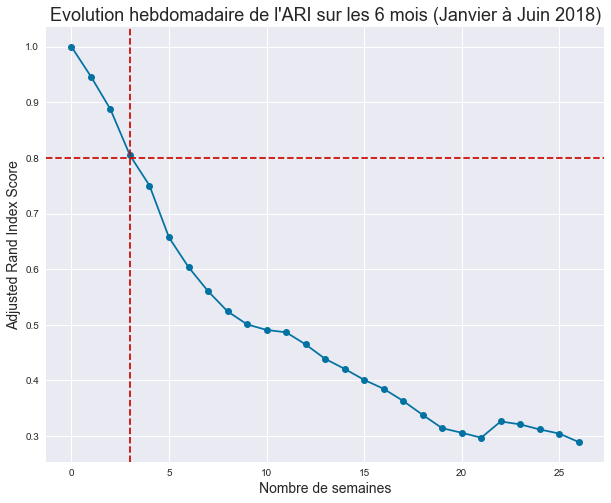

In [74]:
# Graphiquement
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10, 8))
plt.plot(list_ari, marker='o')
plt.axhline(y=0.8, color='r', linestyle='--')
plt.axvline(x=rythme, color='r', linestyle='--')

plt.title(
    "Evolution hebdomadaire de l'ARI sur les 6 mois (Janvier à Juin 2018)",
    fontsize=18)
plt.xlabel('Nombre de semaines', fontsize=14)
plt.ylabel('Adjusted Rand Index Score', fontsize=14)
plt.show()